# Dataset = https://www.kaggle.com/datasets/tongpython/cat-and-dog/data

In [18]:
!nvidia-smi

Wed Jan 17 13:12:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:1E.0 Off |                    0 |
| N/A   41C    P0              32W /  70W |   2173MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install kaggle

In [11]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi



# Set your Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'your_username'
os.environ['KAGGLE_KEY'] = 'your_api_key'



In [ ]:
if not os.path.exists('dogs-cats-images.zip'):
    # Download the dataset
    !kaggle datasets download -d chetankv/dogs-cats-images     

if os.path.exists('dogs-cats-images.zip') and not os.path.exists('cat-and-dog'):
    # Make directory and unzip
    !unzip dogs-cats-images.zip -d cat-and-dog

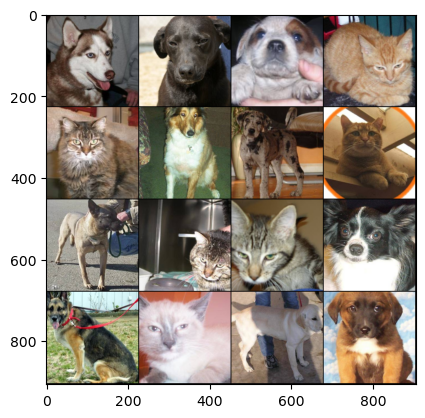

In [24]:
#%% packages
from collections import OrderedDict 
import numpy as np 
import torch 
from torch import optim 
import torch.nn as nn 
import torchvision 
from torchvision import transforms,models 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import accuracy_score
import multiprocessing

# %% data prep
# original data from https://www.microsoft.com/en-us/download/details.aspx?id=54765

train_dir = './cat-and-dog/dog vs cat/dataset/training_set' 
test_dir =  './cat-and-dog/dog vs cat/dataset/test_set'

num_workers = multiprocessing.cpu_count()


transform = transforms.Compose([transforms.Resize(255), 
    transforms.CenterCrop(224), 
    transforms.ToTensor()]) 
 
dataset = torchvision.datasets.ImageFolder(train_dir, transform= transform) 
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=num_workers,shuffle=True) 

dataset = torchvision.datasets.ImageFolder(test_dir, transform= transform) 
test_loader = torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=False) 

# %%
def imshow(image_torch): 
    # flip image channels to RGB
    image_torch = image_torch.numpy().transpose((1, 2, 0)) 
    plt.figure() 
    plt.imshow(image_torch) 
 
X_train, y_train = next(iter(train_loader)) 
 
# Make a grid from batch 
image_grid = torchvision.utils.make_grid(X_train[:16, :, :, :], scale_each= True, nrow=4) 
 
imshow(image_grid) 


In [31]:
# %% download pre-trained network
model = models.densenet121(pretrained = True) 
model 


/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [32]:

#%% modify layers
# freeze all layers
for params in model.parameters(): 
    params.requires_grad = False 

#%% overwrite classifier of model
model.classifier = nn.Sequential(OrderedDict([ 
    ('fc1',nn.Linear(1024,1)), 
    ('Output',nn.Sigmoid()) 
])) 
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Train model

epoch: 0, train_loss: 32.3121532201767 , acc: 0.953125
epoch: 1, train_loss: 12.250701617449522 , acc: 0.984375
epoch: 2, train_loss: 9.846892181783915 , acc: 0.953125
epoch: 3, train_loss: 8.465230153873563 , acc: 0.953125
epoch: 4, train_loss: 7.30864517763257 , acc: 0.984375
epoch: 5, train_loss: 7.1864671455696225 , acc: 0.984375
epoch: 6, train_loss: 6.826041826978326 , acc: 0.96875
epoch: 7, train_loss: 6.358266767114401 , acc: 1.0
epoch: 8, train_loss: 5.815308649558574 , acc: 0.984375
epoch: 9, train_loss: 5.90874947886914 , acc: 1.0


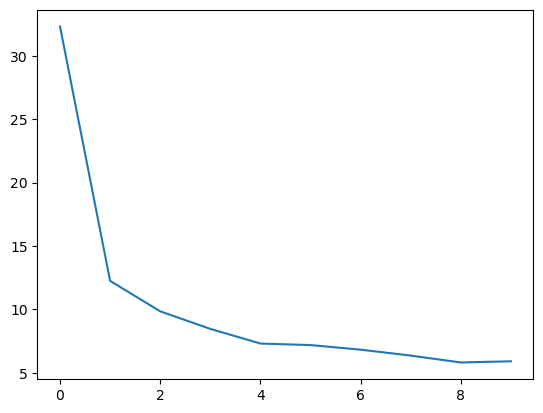

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ...

# %% train the model
opt = optim.Adam(model.classifier.parameters()) 
loss_function = nn.BCELoss() 
train_losses=[] 

model.to(device)  # Move the model to GPU

model.train() 
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS): 
    train_loss= 0 
    test_loss= 0 
    for bat,(img,label) in enumerate(train_loader): 
        img = img.to(device)  # Move the input data to GPU
        label = label.to(device)  # Move the labels to GPU
        
        # zero the gradients
        opt.zero_grad() 

        # forward pass
        output = model(img) 

        # calc losses
        loss = loss_function(output.squeeze(),label.float()) 

        # propagate losses
        loss.backward() 

        # update weights
        opt.step() 

        # update current train loss
        train_loss += loss.item() 

    train_losses.append(train_loss) 
    acc = accuracy_score(label.cpu().detach().numpy().round(), output.cpu().detach().numpy().round())
    print(f"epoch: {epoch}, train_loss: {train_loss} , acc: {acc}")

# %% plot losses
plt.plot(train_losses)